In [1]:
# Libraries used in this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import time

from scipy.sparse import csr_matrix

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# ML task 1 - Predict the department of an art piece

In this first machine learning task, I will be using the table of text data retrieved, cleaned and investigated in 'project-proposal-ChristelChappuis.ipynb'.

The idea behind this first task is to learn some pattern in the way large museums are organized. Indeed, these institutions can have a very extensive collection in extremely various forms, ages, origins etc. In order to operate, the MET museum is organized into different departments. Each piece is assigned to a curatorial department, which is responsible for the artwork. 

The task proposed here is to predict in which department of the MET an art piece is located, given its metadata. This information groups dimensions and medium, artist's information, somes dates (when it was created and when it was acquired my the museum), some general classification and tags, etc. 

From a storytelling perspective, I can pose the problem as such: "let's say I am a new collaborator at the MET and have been given some tasks to perform on a few art pieces. Luckily, I have some information about these art pieces but I am unfortunately unaware of the department where I can find them. Given the information I have, can I predict where, meaning in which department, I should find the pieces ?" 

From a data science perspective, I am particularly interested in handling a table with an important proportion of categorical feature. This characteristic has been a large challenge in the data cleaning part and I am curious to find out how machine learning models handle a large quantity of one-hot encoded features.

## Preparation 

Before jumping into machine learning, let's do some preparation, in particular data importation, train/test splitting and investigate dimensionality reduction, in particular with PCA and t-SNE.

### DataFrame importation

In [2]:
df = pd.read_csv('df_ML1.txt')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205803 entries, 0 to 205802
Data columns (total 37 columns):
Is Highlight           205803 non-null bool
Object ID              205803 non-null int64
Gallery Number         205803 non-null int64
Department             205803 non-null object
AccessionYear          205803 non-null float64
Culture                205803 non-null object
Artist Role            205803 non-null object
Artist Display Name    205803 non-null object
Artist Nationality     205803 non-null object
Artist Begin Date      205803 non-null float64
Artist End Date        205803 non-null float64
Artist Gender          205803 non-null object
Object Begin Date      205803 non-null int64
Object End Date        205803 non-null int64
Medium                 205803 non-null object
Geography Type         205803 non-null object
Country                205803 non-null object
Classification         205803 non-null object
Tags                   205803 non-null object
Artist Century    

In [4]:
# Adapt all numerical features to float 
df = df.astype('float64',errors='ignore')

### Feature matrix and target variable

Let's separate the feature matrix and target variable. Then, I can encode the target variable to numerical values.

I could have done this encoding step after splitting train and test sets but I find it cleaner this way. The datasets are going to be splitted in a stratified fashion, thus all vales of the target variables will be present in train and test sets. Consequently, I do not think performing this action at this point is an issue.

In [5]:
# Extracting features and target variable from the dataframe
X = df.drop(columns='Department')
y = df['Department']

# Encode the target variable into numerical values
label_encoder = LabelEncoder()
label_encoder.fit(y)
y = label_encoder.transform(y)
print('Target variables (after encoding): ', np.unique(y).tolist())
target_names = label_encoder.classes_
print('Target variables names: ', target_names.tolist())

Target variables (after encoding):  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Target variables names:  ['Ancient Near Eastern Art', 'Arms and Armor', 'Arts of Africa, Oceania, and the Americas', 'Asian Art', 'Costume Institute', 'Drawings and Prints', 'Egyptian Art', 'European Sculpture and Decorative Arts', 'Greek and Roman Art', 'Islamic Art', 'Medieval Art', 'Photographs', 'The American Wing']


### Split into train / test sets

Let's split the DataFrame into train / test. I decided not to further split into train / valid as I will be using cross-validation to train the models.

During implementation, it appeared quickly that the size of the dataset led to very long run times. So, I tried different strategies to speed things up, among which reducing the quantity of training data. It turned out only a small proportion of the complete dataset was already enough to train models effectively. Consequently, I decided to use 40% of the dataset for training. On this training set, I will use grid-search with cross-validation. I used only 2 folds in cross-validation, meaning that 20% of the dataset for training and 20% for (internal) validation.

In [6]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size= 0.6, random_state = 0, stratify = y)

print('Sets sizes for training: ', X_tr.shape, y_tr.shape)
print('Sets sizes for testing: ', X_te.shape, y_te.shape)

Sets sizes for training:  (82321, 36) (82321,)
Sets sizes for testing:  (123482, 36) (123482,)


Let's quickly make sure the data was indeed splitted in a stratified fashion.

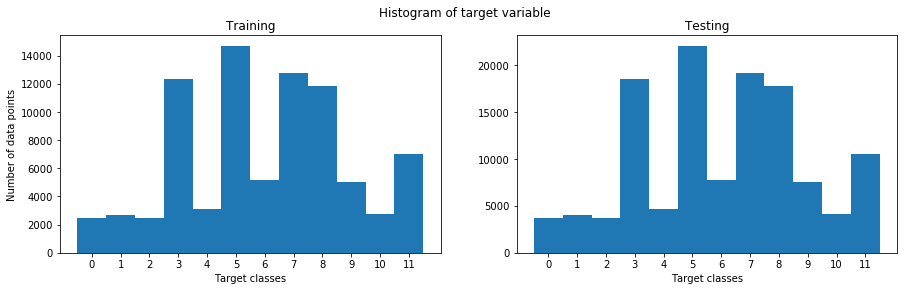

In [7]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(15,4))
fig.suptitle('Histogram of target variable')
ax[0].hist(y_tr,bins=12,align='left')
ax[0].set_title('Training')
ax[0].set_ylabel('Number of data points')
ax[0].set_xlabel('Target classes')
ax[0].set_xticks(np.arange(0,12))
ax[1].hist(y_te,bins=12,align='left')
ax[1].set_xticks(np.arange(0,12))
ax[1].set_xlabel('Target classes')
ax[1].set_title('Testing')
plt.show()

### Sparse matrix

As there are a considerable number of categorical feature with an important number of possible values, I want to investigate the sparsity of the matrix after one-hot encoding. 

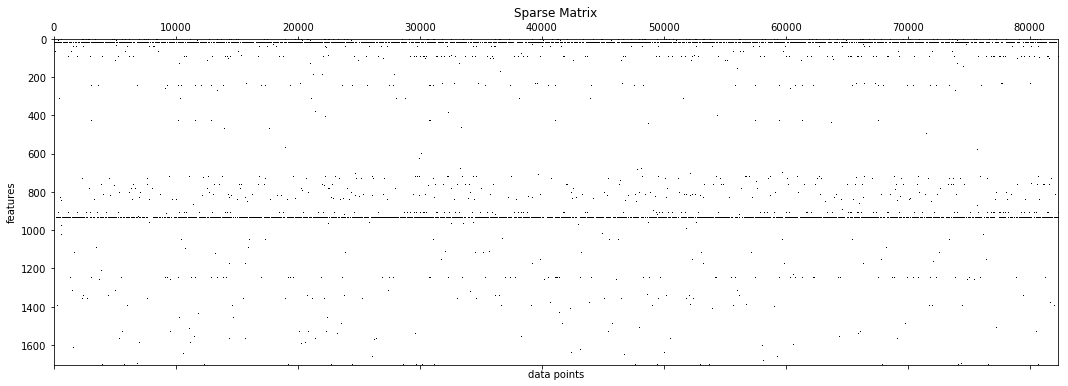

In [8]:
# One-hot encoding
df_encoded_X_tr = pd.get_dummies(X_tr.drop(columns=['Object ID','Is Highlight']))

# Figure - spy to assess the sparsity of the matrix
plt.figure(figsize=(18,6))
plt.spy(df_encoded_X_tr.T,aspect ='auto')
plt.title("Sparse Matrix")
plt.ylabel('features')
plt.xlabel('data points');

Indeed, the data is very sparse. Let's run a quick test inspired by this [link](https://dziganto.github.io/Sparse-Matrices-For-Efficient-Machine-Learning/)
to test if using a sparse matrice might be interesting from a live memory perspective. Basically, I compare how different it is, memory-wise, to store the table in a dense or sparse fashion.

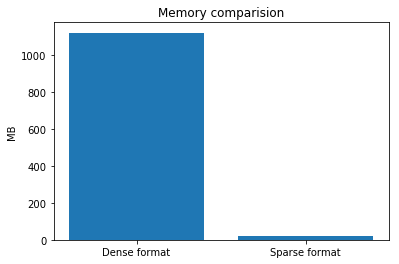

In [9]:
sparse_encoded_X_tr = csr_matrix(df_encoded_X_tr.values.astype('float64'))

dense_memory = np.array(df_encoded_X_tr).nbytes/1e6
sparse_memory = (sparse_encoded_X_tr.data.nbytes + sparse_encoded_X_tr.indptr.nbytes + sparse_encoded_X_tr.indices.nbytes)/1e6

plt.bar(['Dense format', 'Sparse format'], [dense_memory, sparse_memory])
plt.ylabel('MB')
plt.title('Memory comparision')
plt.show()

The difference is quite important ! Thus, I will try to use a sparse format whenever possible with these datasets.

## Preprocessing

Let's now define the preprocessing steps. I have decided to use a ColumnTransformer object to apply different preprocessing to numerical and categorical features. 
- categorical features will be one-hot encoded. I use the parameter 'handle_unknown' set to 'ignore' in order not to consider values in the test set that did not appear in the train set
- numerical features will be standardized with the StandardScaler. I removed two features, 'Object ID' and 'Is Highlight', that are useful to identify the art pieces but should not be informative for the model.

In [10]:
# Categorical features
cat_columns = X.select_dtypes(exclude='number').columns.tolist()
cat_transformer = OneHotEncoder(handle_unknown='ignore', sparse=True)

In [11]:
# Numerical featuers
num_columns = X.select_dtypes(exclude='object_').columns.tolist()
num_columns.remove('Object ID')
num_columns.remove('Is Highlight')
num_transformer = StandardScaler()

In [12]:
# Create the column transformer
preprocessor = ColumnTransformer([
    ('categorical', cat_transformer, cat_columns),
    ('numerical', num_transformer, num_columns),
], remainder='drop')

X_tr_prepro = preprocessor.fit_transform(X_tr)
X_tr_prepro.shape

(82321, 1704)

As already mentionned, when I was building models, tuning hyperparameters and running cross-validation, I quickly faced an important challenge for my current computational settings. Running time was very important and I searched for ways to reduce it.

At first, I made a pipeline for each classifier. This pipeline was then given to the GridSearchCV. This pipeline contained the preprocessing, PCA and finally classifier. However, running this entire pipeline for each iteration of the GridSearchCV was extremely time-consuming. I thus decided to simplify a little the setup, although I do realize it is not strictly adequate for the validation set in GridSearch. Instead of the pipeline, I simply pass the classifier into GridSearchCV. The preprocessing and extraction of PCA principal components are performed only once at the beginning. It means the validation set inside the GridSearchCV has been treated as part of the training set for preprocessing and PCA. It is not great but it clearly appeared as a necessary sacrifice for this project on my personal setups.

However, here is the structure of the pipeline that I wanted to use in the first place (if I could have done it more properly). For example, for the logistic regression : 

pipe_logreg = Pipeline([

                        (‘preprocessor’, preprocessor), 
                        (‘pca’, PCA(n_components=40)),
                        (‘classifier’, LogisticRegression(multi_class='multinomial',class_weight='balanced',random_state=0))
            
                        ])

Followed by the cross-validation grid-search: 

gridCV_logreg = GridSearchCV(

                            pipe_logreg, 
                            grid_logreg, 
                            cv=cv, 
                            return_train_score=True,
                            n_jobs=-1,
                            scoring = ['f1_micro']
                            )



## Dimensionality reduction

### Truncated SVD

I found PCA and t-SNE did not accept sparse matrix as input. However, Truncated SVD does, so I decided to test it.

Also, I will be reporting a lot of running time through this notebook. The long running time was clearly a challenge for this implementation and thus an interesting discussion point.

In [13]:
# Initialize timer
time_start = time.time()

tSVD = TruncatedSVD()

X_prepro_2d_tSVD = tSVD.fit_transform(X_tr_prepro)

print('Time to fit-transform with Truncated SVD:',round(time.time()-time_start,3), 's')

Time to fit-transform with Truncated SVD: 0.889 s


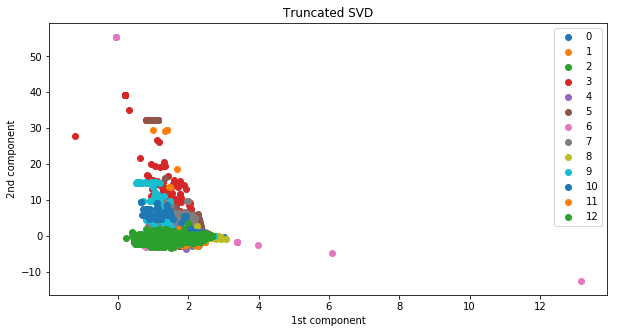

In [14]:
# Create figure
fig = plt.figure(figsize=(10,5))
target_variables = np.unique(y_tr).tolist()
for kind in np.arange(len(target_variables)):
    # Image samples of this type
    idx = (y_tr == kind)
    var = target_variables[kind]

    # Plot their components
    plt.scatter(X_prepro_2d_tSVD[idx, 0], X_prepro_2d_tSVD[idx, 1], label=var)
    
# Labels and legend
plt.legend()
plt.title('Truncated SVD')
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.show()

No structure in the data is identified with truncated SVD. Let's try PCA and t-SNE.

### PCA

Firstly, I want to try PCA with the defined preprocessor. With this preprocessor, the one-hot encoded features (binary features) do not go through the StandardScaler. 

In [15]:
# Initialize timer
time_start = time.time()

# Create PCA transformer
pca = PCA(n_components=None)

# Apply PCA to rescaled data (dense matrix)
X_tr_preproD = X_tr_prepro.toarray()
pca.fit(X_tr_preproD)

# Proportion of variance explained
pve = pca.explained_variance_ratio_

print('Time to fit with PCA on partially scaled data:',round(time.time()-time_start,3), 's')

Time to fit with PCA on partially scaled data: 44.034 s


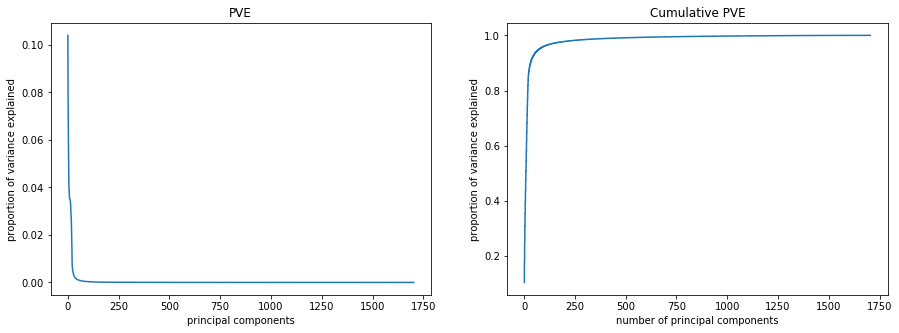

10% of the variance is explained by : 1 principal components
20% of the variance is explained by : 3 principal components
30% of the variance is explained by : 4 principal components
40% of the variance is explained by : 7 principal components
50% of the variance is explained by : 9 principal components
60% of the variance is explained by : 12 principal components
70% of the variance is explained by : 15 principal components
80% of the variance is explained by : 19 principal components
90% of the variance is explained by : 32 principal components
100% of the variance is explained by : 1705 principal components


In [16]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(15,5))

# PVE per principal components
ax[0].plot(pve)
ax[0].set_ylabel('proportion of variance explained')
ax[0].set_xlabel('principal components')
ax[0].set_title('PVE')

# Cumulative PVE
xcor = np.arange(1, len(pve) + 1)
pve_cumsum = np.cumsum(pve)
ax[1].step(xcor+0.5,pve_cumsum)
ax[1].set_xlabel('number of principal components')
ax[1].set_ylabel('proportion of variance explained')
ax[1].set_title('Cumulative PVE')
plt.show()

for i in np.arange(0.1, 1.1, 0.1):
    nb_principal_component = np.size(pve_cumsum) - np.count_nonzero(pve_cumsum>i) + 1
    print('{:.0f}% of the variance is explained by : {} principal components'.format(i*100,nb_principal_component))

In [17]:
# Create DataFrame with variance and principal components
PCA_results = pd.DataFrame({
    'variance': X_tr_prepro.toarray().var(axis=0),
    '1st component': pca.components_[0],
    '2nd component': pca.components_[1]
}).set_index(df_encoded_X_tr.columns)

# Sort DataFrame by the coefficients of the 1st loading vector
PCA_results.sort_values('1st component', ascending=False).head(10)

,variance,1st component,2nd component
Tags_Vestments,1.000000,0.095473,0.294975
Tags_Writing Implements,1.000000,0.068439,0.527289
Culture_Teotihuacan,0.165460,0.060164,0.054001
Tags_Venus,1.000000,0.049796,0.454011
Tags_Utilitarian Objects,1.000000,0.042753,0.401192
Tags_Urns,1.000000,0.038565,0.383011
Classification_Ojime,0.084204,0.035821,0.016916
Artist Display Name_William and Henry Rock,0.031359,0.031176,0.002365
Culture_Scottish,0.226679,0.026651,-0.006572
Medium_Faience,0.049637,0.022070,0.007817


#### PCA biplot

Let's create the 2d-plot of the features with PCA using the first two components. 

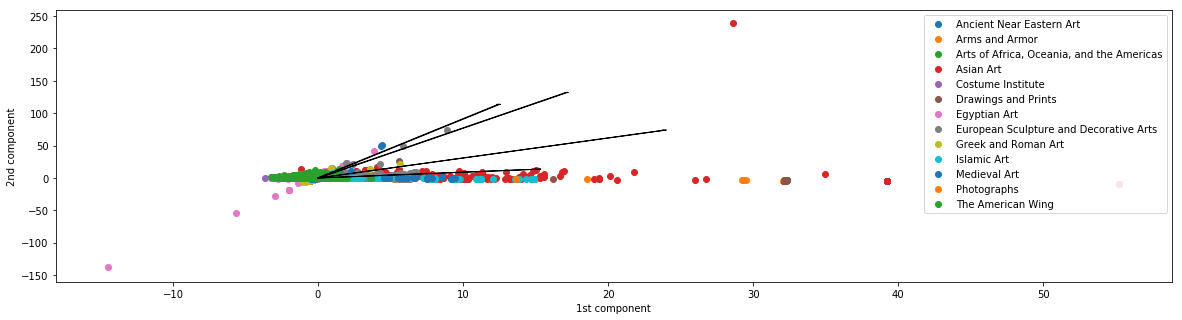

In [18]:
# Let's project data onto the first two components
X_tr_prepro_2d = pca.transform(X_tr_preproD)[:,0:2]

# Create figure
fig = plt.figure(figsize=(20,5))

for kind in np.unique(y).tolist():
    # Image samples of this type
    idx = (y_tr == kind)
    cat = target_names[kind]

    # Plot their components
    plt.scatter(X_tr_prepro_2d[idx, 0], X_tr_prepro_2d[idx, 1], label=cat)

pick1 = PCA_results.sort_values('1st component', ascending=False).iloc[0:4,:].index.tolist()

# Plot a few features (selected from the DataFrame above)
for feature in pick1:
    # Extract the weights
    weight1 = PCA_results.loc[feature, '1st component']*250
    weight2 = PCA_results.loc[feature, '2nd component']*250

    # Plot arrows
    plt.arrow(0, 0, weight1, weight2, color='black', width=0.1)
    
# Labels and legend
plt.legend()
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.show()

No clear structure is extracted from the dataset with the 2 first components of PCA.

### PCA with scaling of all features (even binary)

Let's try now PCA but with scaling of all features, including binary features. 

In [19]:
# Initialize timer
time_start = time.time()

# Create PCA transformer
pca2 = PCA(n_components=None)

# One-hot encoding and scaling of the features
scaler = StandardScaler()
X_tr_ALLscaled = scaler.fit_transform(pd.get_dummies(X_tr).astype('float'))

# Apply PCA to rescaled data
pca2.fit(X_tr_ALLscaled)

# Proportion of variance explained
pve2 = pca2.explained_variance_ratio_

print('Time to fit with PCA on completely scaled data:',round(time.time()-time_start,3), 's')

Time to fit with PCA on completely scaled data: 47.625 s


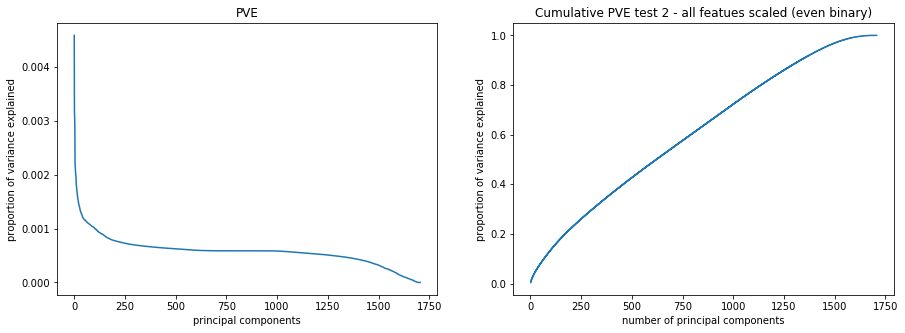

10% of the variance is explained by : 67 principal components
20% of the variance is explained by : 171 principal components
30% of the variance is explained by : 306 principal components
40% of the variance is explained by : 457 principal components
50% of the variance is explained by : 621 principal components
60% of the variance is explained by : 791 principal components
70% of the variance is explained by : 961 principal components
80% of the variance is explained by : 1137 principal components
90% of the variance is explained by : 1331 principal components
100% of the variance is explained by : 1707 principal components


In [20]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(15,5))

# PVE per principal components
ax[0].plot(pve2)
ax[0].set_ylabel('proportion of variance explained')
ax[0].set_xlabel('principal components')
ax[0].set_title('PVE')

# Cumulative PVE
xcor = np.arange(1, len(pve2) + 1)
pve_cumsum2 = np.cumsum(pve2)
ax[1].step(xcor+0.5,pve_cumsum2)
ax[1].set_xlabel('number of principal components')
ax[1].set_ylabel('proportion of variance explained')
ax[1].set_title('Cumulative PVE test 2 - all featues scaled (even binary)')
plt.show()

for i in np.arange(0.1, 1.1, 0.1):
    nb_principal_component = np.size(pve_cumsum2) - np.count_nonzero(pve_cumsum2>i) + 1
    print('{:.0f}% of the variance is explained by : {} principal components'.format(i*100,nb_principal_component))

#### PCA biplot

Let's create the 2d-plot of the features with PCA using the first two components. 

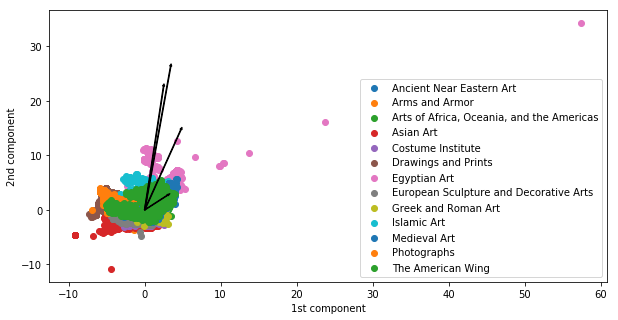

In [21]:
# Let's project data onto the first two components
X_tr_ALLscaled_2d = pca2.transform(X_tr_ALLscaled)[:,0:2]

# Create figure
fig = plt.figure(figsize=(10,5))

for kind in np.unique(y).tolist():
    # Image samples of this type
    idx = (y_tr == kind)
    cat = target_names[kind]

    # Plot their components
    plt.scatter(X_tr_ALLscaled_2d[idx, 0], X_tr_ALLscaled_2d[idx, 1], label=cat)

pick1 = PCA_results.sort_values('1st component', ascending=False).iloc[0:4,:].index.tolist()

# Plot a few features (selected from the DataFrame above)
for feature in pick1:
    # Extract the weights
    weight1 = PCA_results.loc[feature, '1st component']*50
    weight2 = PCA_results.loc[feature, '2nd component']*50

    # Plot arrows
    plt.arrow(0, 0, weight1, weight2, color='black', width=0.1)
    
# Labels and legend
plt.legend()
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.show()

Here again, no clear structure is extracted from the dataset with the 2 first components of PCA. However, the proportion of explained variance looked better on the first try, without scaling binary features.

After countless research on the internet, I have not been able to come up with an absolutely correct choice regarding the scaling of binary features. It seems both perspective, scaling or not, can be argumented and defended. 

I am thus making a choice based on my intuition for now, hopefully more experience in the future might be able to bring more robustness in my choices regarding this topic. Intuitively, I prefer not to scale binary features because they are already standardized in a certain way, although the mean is not 0. Moreover, the 0-1 values, representing no-yes, are shared among all one-hot encoded features. If I force the mean to 0, then the "no" value for feature A will be numerically different than the "no" value for feature B. 

### t-SNE

Let's move on to the last dimensionality reduction technique tested here. I used two sources to understand and guide my implementation of t-SNE:
- [the scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)
- [this tutorial by datacamp](https://www.datacamp.com/community/tutorials/introduction-t-sne)

In [22]:
# Initialize timer
time_start = time.time()

# Select 40 components from PCA
X_tr_PCA_40d = pca.transform(X_tr_preproD)[:,0:40]

print('Time to transform with PCA:',round(time.time()-time_start,3), 's')

Time to transform with PCA: 11.224 s


In [23]:
# Initialize timer
time_start = time.time()

# Create t-SNE 
tSNE = TSNE(random_state=0)

# Run t-SNE
X_tr_PCA_tSNE = tSNE.fit_transform(X_tr_PCA_40d)

print('Time to fit-transform with tSNE:',round(time.time()-time_start,3), 's')

Time to fit-transform with tSNE: 1551.312 s


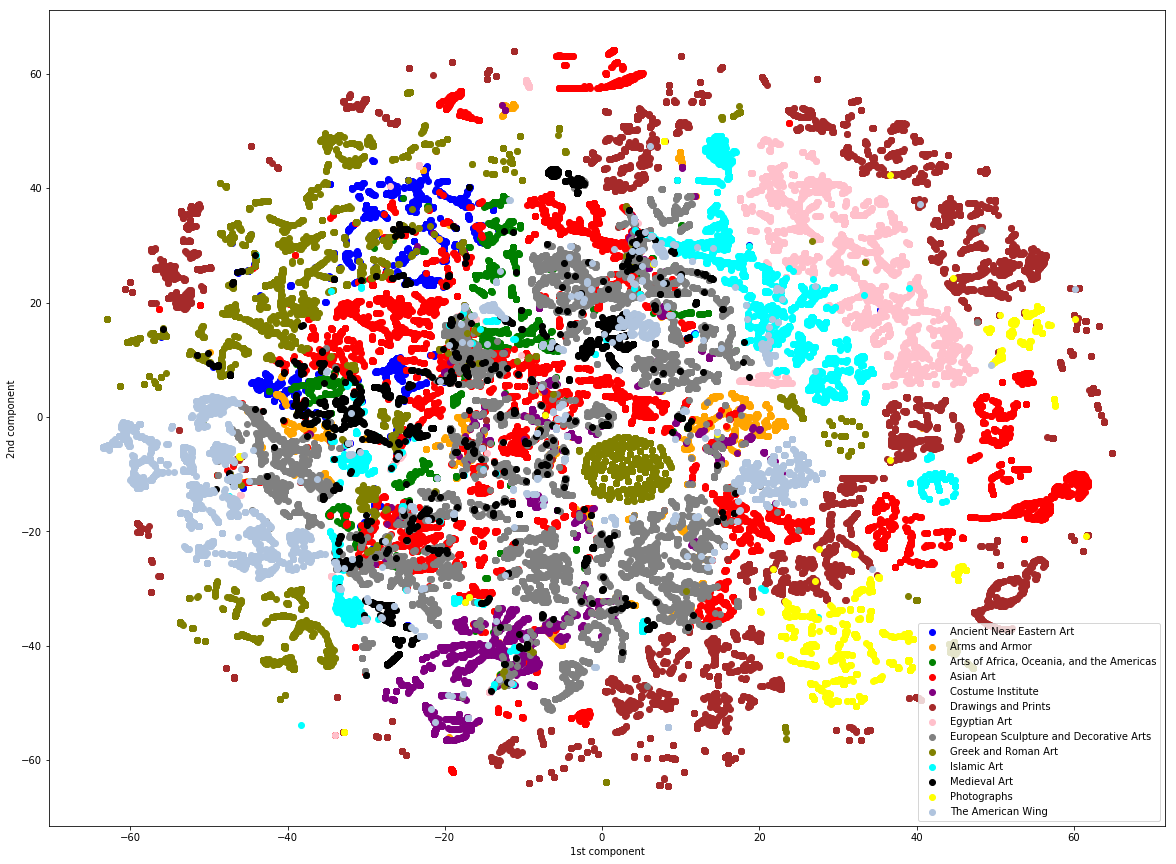

In [24]:
# Create figure
fig = plt.figure(figsize=(20,15))
colors = ['blue','orange','green','red','purple','brown','pink','grey','olive','cyan','black','yellow','lightsteelblue']

cnt = 0
for kind in np.unique(y).tolist():
    # Image samples of this type
    idx = (y_tr == kind)
    cat = target_names[kind]

    # Plot their components
    plt.scatter(X_tr_PCA_tSNE[idx, 0], X_tr_PCA_tSNE[idx, 1], label=cat,c=colors[cnt])
    cnt=cnt+1
    
# Labels and legend
plt.legend()
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.show()

With the first two components of t-SNE, we see some structure appearing in the data. It is still a little blurred and some target variables are still quite dispersed over the graph but it looks much better than PCA alone.

Side note about UMAP: I finally decided not to perform UMAP. The requirements for its installation asked for high versions of the packages contained in the environement used for the class. I did not want to risk versioning / depreciation issues at this point.


## Models training and validation

Let's address the machine learning proper now.

Firstly, I set a few parameters that are going to be used throughout the implementation for all models. 
- About the average_strategy for the f1 score, I was hesitating between 'micro' and 'weighted' but finally decided for the former. For a multi-class classification, I found it is advised to use micro-average if there is a class imbalance, which is clearly the case here.
- I had to filter out depreciation warnings (for cleaner outputs) because it was always triggered when using 'n_jobs=-1' in GridSearchCV. It is possible updating some packages in the environment might have solved this issue in a more durable way but again I did not want to risk versioning inconsistencies between packages.

In [25]:
# for f1_score
average_strategy = 'micro' # for f1_score, 'micro' or 'weighted'

# for cross-validation in grid-search
cv = 2

# sparse matrix instead of dense for efficiency
X_tr_PCA_40d = csr_matrix(X_tr_PCA_40d)

# Filter out depreciation warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

### Baseline

Let's first look into baselines. I decided to use the DummyClassifier from sklearn and tested the different strategy available. 

In [26]:
# Initialize timer
time_start = time.time()

dummy_mf = DummyClassifier(strategy="most_frequent")
dummy_mf.fit(None,y_tr)
y_pred_mf = dummy_mf.predict(X_te)

time_baseline = round(time.time()-time_start,3)

dummy_stratified = DummyClassifier(strategy="stratified")
dummy_stratified.fit(None,y_tr)
y_pred_stratified = dummy_stratified.predict(X_te)

dummy_prior = DummyClassifier(strategy="prior")
dummy_prior.fit(None,y_tr)
y_pred_prior = dummy_prior.predict(X_te)

dummy_uniform = DummyClassifier(strategy="uniform")
dummy_uniform.fit(None,y_tr)
y_pred_uniform = dummy_uniform.predict(X_te)

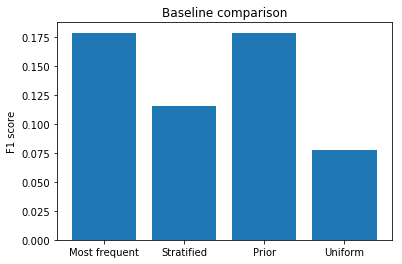

In [27]:
# Plot the baseline
plt.bar(x=['Most frequent','Stratified','Prior','Uniform'],
       height=[f1_score(y_te,y_pred_mf,average=average_strategy), f1_score(y_te,y_pred_stratified,average=average_strategy),
              f1_score(y_te,y_pred_prior,average=average_strategy), f1_score(y_te,y_pred_uniform,average=average_strategy)])
plt.ylabel('F1 score')
plt.title('Baseline comparison')
plt.show()

To make for a slightly stronger baseline, I decided to go with the strategy 'Most frequent'. This baseline will be used in the final comparison between models.

### Logistic Regression

I start with a logistic regression on the 40th first components of PCA. For the logistic regression, I set the parameters 'multi_class' and 'class_weight' to the value most appropriate for multi-class and imbalanced datasets.

I test different values of the C parameter with solver 'sag' and 'saga' (potentially more appropriate for multiclass problem).

In [28]:
logreg = LogisticRegression(multi_class='multinomial',class_weight='balanced',max_iter=200,random_state=0) # multinomial for cross-enthropy

# Create cross-validation object
grid_logreg = {
    'C': [0.01,0.1,1,10,50,100],
    'solver':['sag','saga']
}
gridCV_logreg = GridSearchCV(logreg, grid_logreg, cv=cv, return_train_score=True,n_jobs=-1,scoring = ['f1_micro'],refit=False)

# Fit estimator
gridCV_logreg.fit(X_tr_PCA_40d, y_tr)

# Collect results in a DataFrame
cv_res_logreg = pd.DataFrame(gridCV_logreg.cv_results_)

# Print a few interesting columns
cols = ['mean_test_f1_micro', 'std_test_f1_micro', 'mean_train_f1_micro', 'std_train_f1_micro', 'param_C', 'param_solver']
cv_res_logreg[cols].sort_values('mean_test_f1_micro', ascending=False)

,mean_test_f1_micro,std_test_f1_micro,mean_train_f1_micro,std_train_f1_micro,param_C,param_solver
8,0.906367,0.004768,0.906877,0.003298,50,sag
10,0.906367,0.004768,0.906889,0.003286,100,sag
6,0.906354,0.004755,0.906877,0.003298,10,sag
4,0.906269,0.004792,0.906695,0.003262,1,sag
2,0.905067,0.004707,0.905686,0.003226,0.1,sag
0,0.891340,0.002545,0.892348,0.002326,0.01,sag
9,0.885558,0.006482,0.886566,0.005532,50,saga
11,0.885558,0.006482,0.886566,0.005532,100,saga
7,0.885546,0.006469,0.886566,0.005532,10,saga
5,0.885448,0.006469,0.886421,0.005460,1,saga


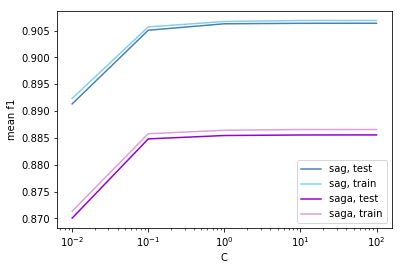

In [29]:
cnt = 0
color = ['steelblue','skyblue','darkviolet','plum']
for solver, table in cv_res_logreg[cols].groupby(['param_solver']):
    plt.plot(table['param_C'],table['mean_test_f1_micro'],c=color[cnt],label=str(solver)+', test')
    plt.plot(table['param_C'],table['mean_train_f1_micro'],c=color[cnt+1],label=str(solver)+', train')
    cnt = cnt+2

plt.xscale('log')
plt.xlabel('C')
plt.ylabel('mean f1')
plt.legend(loc='best')
plt.show()

In [30]:
# Initialize timer
time_start = time.time()

# Fit the best estimator
logreg.set_params(C = cv_res_logreg['param_C'][cv_res_logreg['mean_test_f1_micro'].idxmax()],
                  solver = cv_res_logreg['param_solver'][cv_res_logreg['mean_test_f1_micro'].idxmax()]
                 )
logreg.fit(X_tr_PCA_40d, y_tr)

print('F1 score for logistic regression on train set:',round(f1_score(y_tr,logreg.predict(X_tr_PCA_40d),average=average_strategy),3))
time_logreg = round(time.time()-time_start,3)
print('Time to fit/predict with LogReg:',time_logreg, 's')

F1 score for logistic regression on train set: 0.916
Time to fit/predict with LogReg: 43.959 s


C:\Users\christel\anaconda3\envs\exts-ml\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


It seems a lighter regularization (higher C value) is preferred by the model. 

Also, I notice the model runs quite rapidly. 

### K nearest neighbours

For this classifer, I want to test different values for the number of neighbors to consider as well as the weights applied to each neigboring value.

In [31]:
knn = KNeighborsClassifier()

# Create cross-validation object
grid_knn = {
    'n_neighbors': [1,2,3,5,10],
    'weights':['uniform','distance']
}
gridCV_knn = GridSearchCV(knn, grid_knn, cv=cv, return_train_score=True,n_jobs=-1,scoring = ['f1_micro'],refit=False)

# Fit estimator
gridCV_knn.fit(X_tr_PCA_40d, y_tr)

# Collect results in a DataFrame
cv_res_knn = pd.DataFrame(gridCV_knn.cv_results_)

# Print a few interesting columns
cols = ['mean_test_f1_micro', 'std_test_f1_micro', 'mean_train_f1_micro', 'std_train_f1_micro', 'param_n_neighbors', 'param_weights']
cv_res_knn[cols].sort_values('mean_test_f1_micro', ascending=False)

,mean_test_f1_micro,std_test_f1_micro,mean_train_f1_micro,std_train_f1_micro,param_n_neighbors,param_weights
5,0.968501,0.000038,1.000000,0.000000,3,distance
0,0.968404,0.000014,1.000000,0.000000,1,uniform
1,0.968404,0.000014,1.000000,0.000000,1,distance
3,0.968404,0.000014,1.000000,0.000000,2,distance
7,0.967129,0.000245,1.000000,0.000000,5,distance
4,0.964323,0.000039,0.980855,0.000317,3,uniform
9,0.963011,0.000374,1.000000,0.000000,10,distance
2,0.962913,0.000763,0.982969,0.000074,2,uniform
6,0.960994,0.000374,0.973530,0.000205,5,uniform
8,0.953123,0.000058,0.961602,0.000277,10,uniform


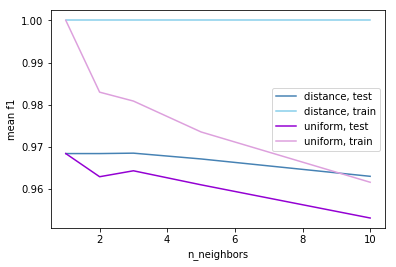

In [32]:
cnt = 0
color = ['steelblue','skyblue','darkviolet','plum']
for weights, table in cv_res_knn[cols].groupby(['param_weights']):
    plt.plot(table['param_n_neighbors'],table['mean_test_f1_micro'],c=color[cnt],label=str(weights)+', test')
    plt.plot(table['param_n_neighbors'],table['mean_train_f1_micro'],c=color[cnt+1],label=str(weights)+', train')
    cnt = cnt+2

plt.xlabel('n_neighbors')
plt.ylabel('mean f1')
plt.legend(loc='best')
plt.show()

In [33]:
# Initialize timer
time_start = time.time()

# Fit the best estimator
knn.set_params(n_neighbors = cv_res_knn['param_n_neighbors'][cv_res_knn['mean_test_f1_micro'].idxmax()],
                  weights = cv_res_knn['param_weights'][cv_res_knn['mean_test_f1_micro'].idxmax()]
                 )
knn.fit(X_tr_PCA_40d, y_tr)

print('F1 score for knn on train set:',round(f1_score(y_tr,knn.predict(X_tr_PCA_40d),average=average_strategy),3))
time_knn = round(time.time()-time_start,3)
print('Time to fit/predict with kNN:',time_knn, 's')

F1 score for knn on train set: 1.0
Time to fit/predict with kNN: 724.369 s


It appears considering a small number of neighboring values (3 in that case, although the difference in test f1 score is extremely small) is best. In terms of weight, distance weight performs generally better than distance weight. 

I note the time to run kNN is relatively long.

### Decision tree

For the decision trees and random forests, I want to test two strategies: 
- preprocessed features
- 40th first components of PCA (previsouly preprocessed in the same way than the first strategy)

For both type of classifier, I am careful to set the parameter 'class_weight' to 'balanced' because the dataset is imbalanced.

For decision trees, I want to test different values for the parameters 'criterion' and the maximum depth of the tree. 

#### Decision tree on data with prior PCA treatment

In [34]:
dt_pca = DecisionTreeClassifier(random_state=0,class_weight='balanced')

# Create cross-validation object
grid_dt = {
    'criterion': ['gini','entropy'],
    'max_depth':[5,15,50,None]
}
gridCV_dt_pca = GridSearchCV(dt_pca, grid_dt, cv=cv, return_train_score=True,scoring = ['f1_micro'],refit=False)

# Fit estimator
gridCV_dt_pca.fit(X_tr_PCA_40d, y_tr)

# Collect results in a DataFrame
cv_res_dt_pca = pd.DataFrame(gridCV_dt_pca.cv_results_)

# Print a few interesting columns
cols = ['mean_test_f1_micro', 'std_test_f1_micro', 'mean_train_f1_micro', 'std_train_f1_micro', 'param_criterion', 'param_max_depth']
cv_res_dt_pca[cols].sort_values('mean_test_f1_micro', ascending=False)

,mean_test_f1_micro,std_test_f1_micro,mean_train_f1_micro,std_train_f1_micro,param_criterion,param_max_depth
6,0.950839,0.000446,1.000000,0.000000,entropy,50
7,0.950839,0.000446,1.000000,0.000000,entropy,None
2,0.947608,0.000689,1.000000,0.000000,gini,50
3,0.947608,0.000689,1.000000,0.000000,gini,None
5,0.945579,0.000756,0.988691,0.001251,entropy,15
1,0.929690,0.000029,0.966703,0.001958,gini,15
4,0.718723,0.004645,0.723667,0.002291,entropy,5
0,0.546373,0.016317,0.549715,0.016906,gini,5


In [35]:
# Initialize timer
time_start = time.time()

# Fit the best estimator
dt_pca.set_params(criterion = cv_res_dt_pca['param_criterion'][cv_res_dt_pca['mean_test_f1_micro'].idxmax()],
                  max_depth = cv_res_dt_pca['param_max_depth'][cv_res_dt_pca['mean_test_f1_micro'].idxmax()]
                 )
dt_pca.fit(X_tr_PCA_40d, y_tr)

print('F1 score for decision tree on train set:',round(f1_score(y_tr,dt_pca.predict(X_tr_PCA_40d),average=average_strategy),3))
print('Time to fit/predict with decision tree on data from PCA:',round(time.time()-time_start,3), 's')

F1 score for decision tree on train set: 1.0
Time to fit/predict with decision tree on data from PCA: 18.61 s


#### Decision tree on preprocessed data directly

In [36]:
dt = DecisionTreeClassifier(random_state=0,class_weight='balanced')

# Create cross-validation object
grid_dt = {
    'criterion': ['gini','entropy'],
    'max_depth':[5,15,50,None]
}
gridCV_dt = GridSearchCV(dt, grid_dt, cv=cv, return_train_score=True,scoring = ['f1_micro'],refit=False)

# Fit estimator
gridCV_dt.fit(X_tr_prepro, y_tr)

# Collect results in a DataFrame
cv_res_dt = pd.DataFrame(gridCV_dt.cv_results_)

# Print a few interesting columns
cols = ['mean_test_f1_micro', 'std_test_f1_micro', 'mean_train_f1_micro', 'std_train_f1_micro', 'param_criterion', 'param_max_depth']
cv_res_dt[cols].sort_values('mean_test_f1_micro', ascending=False)

,mean_test_f1_micro,std_test_f1_micro,mean_train_f1_micro,std_train_f1_micro,param_criterion,param_max_depth
3,0.988423,0.000667,1.000000,0.000000,gini,None
2,0.988241,0.000485,0.999988,0.000012,gini,50
6,0.986407,0.000837,1.000000,0.000000,entropy,50
7,0.986407,0.000837,1.000000,0.000000,entropy,None
5,0.980127,0.001699,0.989747,0.001556,entropy,15
1,0.978632,0.001906,0.986735,0.001604,gini,15
0,0.781878,0.014855,0.784975,0.014335,gini,5
4,0.743480,0.000173,0.744282,0.000604,entropy,5


In [37]:
# Initialize timer
time_start = time.time()

# Fit the best estimator
dt.set_params(criterion = cv_res_dt['param_criterion'][cv_res_dt['mean_test_f1_micro'].idxmax()],
                  max_depth = cv_res_dt['param_max_depth'][cv_res_dt['mean_test_f1_micro'].idxmax()]
                 )
dt.fit(X_tr_prepro, y_tr)

print('F1 score for decision tree on train set:',round(f1_score(y_tr,dt.predict(X_tr_prepro),average=average_strategy),3))
time_dt = round(time.time()-time_start,3)
print('Time to fit/predict with decision tree:',time_dt, 's')

F1 score for decision tree on train set: 1.0
Time to fit/predict with decision tree: 4.412 s


A very useful method of the decision tree classifier is 'feature_importances_' that allows to identify which features are primarly used by the classifier. I chose this approach to investigate the choices of the classifer, instead of the plotting the tree with graphviz, for conveniance. Indeed, plotting a tree of large depth was not very practical visually here.

In [38]:
imp = dt.feature_importances_
cat_transformer.fit(X_tr[cat_columns])
cat_feat = cat_transformer.get_feature_names(cat_columns).tolist()
feat = cat_feat + num_columns
pd.DataFrame(imp,index=feat,columns=['Feature importance']).sort_values(by='Feature importance',ascending=False).head(20)

,Feature importance
Object Begin Date,0.212038
Geography Type_Unknown,0.142608
Culture_Unknown,0.075631
Country_Unknown,0.070237
Culture_American,0.054023
Classification_Photographs,0.048462
Height,0.046950
Medium_Terracotta,0.044012
Culture_China,0.035505
AccessionYear,0.030735


It appears the decision tree model running on the preprocessed features directly (no PCA) performs better. Also, using preprocessed features instead of the PCA principal components allows for more interpretation with the feature_importance method of decision trees.

For this classifier, the criterion that work best is 'gini' and the maximum depth. 

I note that decision tree are especially fast to run, but also that running on the PCA principal components is slower than on the data directly.

### Random forest

For the decision trees and random forests, I want to test two strategies: 
- preprocessed features
- 40th first components of PCA (previsouly preprocessed in the same way than the first strategy)

For both type of classifier, I am careful to set the parameter 'class_weight' to 'balanced' because the dataset is imbalanced.

For random forests, in addition to the parameters 'criterion' and the maximum depth of the tree (similar to decision tree), I also want to test the number of estimators that perform best. 

#### Random forest on data with prior PCA treatment

In [39]:
rf_pca = RandomForestClassifier(class_weight='balanced',random_state=0)

# Create cross-validation object
grid_rf = {
    'n_estimators': [10,100,200],
    'criterion': ['gini','entropy'],
    'max_depth': [10, 100]
}
gridCV_rf_pca = GridSearchCV(rf_pca, grid_rf, cv=cv, return_train_score=True,n_jobs=-1,scoring = ['f1_micro'],refit=False)

# Fit estimator
gridCV_rf_pca.fit(X_tr_PCA_40d, y_tr)

# Collect results in a DataFrame
cv_res_rf_pca = pd.DataFrame(gridCV_rf_pca.cv_results_)

# Print a few interesting columns
cols = ['mean_test_f1_micro', 'std_test_f1_micro', 'mean_train_f1_micro', 'std_train_f1_micro', 'param_n_estimators', 'param_criterion', 'param_max_depth']
cv_res_rf_pca[cols].sort_values('mean_test_f1_micro', ascending=False)

,mean_test_f1_micro,std_test_f1_micro,mean_train_f1_micro,std_train_f1_micro,param_n_estimators,param_criterion,param_max_depth
11,0.980418,0.000876,1.000000,0.000000,200,entropy,100
10,0.980127,0.000827,1.000000,0.000000,100,entropy,100
5,0.980066,0.000475,1.000000,0.000000,200,gini,100
4,0.979944,0.000596,0.999988,0.000012,100,gini,100
3,0.973834,0.000269,0.999223,0.000073,10,gini,100
9,0.973786,0.001265,0.999125,0.000097,10,entropy,100
8,0.969680,0.000682,0.983394,0.000011,200,entropy,10
7,0.968878,0.001095,0.982872,0.000048,100,entropy,10
2,0.960253,0.000756,0.972206,0.000387,200,gini,10
1,0.959719,0.001096,0.971769,0.000849,100,gini,10


In [40]:
# Initialize timer
time_start = time.time()

# Fit the best estimator
rf_pca.set_params(criterion = cv_res_rf_pca['param_criterion'][cv_res_rf_pca['mean_test_f1_micro'].idxmax()],
                  max_depth = cv_res_rf_pca['param_max_depth'][cv_res_rf_pca['mean_test_f1_micro'].idxmax()],
                  n_estimators = cv_res_rf_pca['param_n_estimators'][cv_res_rf_pca['mean_test_f1_micro'].idxmax()]                  
                 )
rf_pca.fit(X_tr_PCA_40d, y_tr)

print('F1 score for random forest on train set:',round(f1_score(y_tr,rf_pca.predict(X_tr_PCA_40d),average=average_strategy),3))
print('Time to fit/predict with random forest on data from PCA:',round(time.time()-time_start,3), 's')

F1 score for random forest on train set: 1.0
Time to fit/predict with random forest on data from PCA: 513.85 s


#### Random forest on preprocessed data directly

In [41]:
rf = RandomForestClassifier(class_weight='balanced',random_state=0)

# Create cross-validation object
grid_rf = {
    'n_estimators': [10,100,200],
    'criterion': ['gini','entropy'],
    'max_depth': [10, 100,None]
}
gridCV_rf = GridSearchCV(rf, grid_rf, cv=cv, return_train_score=True,n_jobs=-1,scoring = ['f1_micro'],refit=False)

# Fit estimator
gridCV_rf.fit(X_tr_prepro, y_tr)

# Collect results in a DataFrame
cv_res_rf = pd.DataFrame(gridCV_rf.cv_results_)

# Print a few interesting columns
cols = ['mean_test_f1_micro', 'std_test_f1_micro', 'mean_train_f1_micro', 'std_train_f1_micro', 'param_n_estimators', 'param_criterion', 'param_max_depth']
cv_res_rf[cols].sort_values('mean_test_f1_micro', ascending=False)

,mean_test_f1_micro,std_test_f1_micro,mean_train_f1_micro,std_train_f1_micro,param_n_estimators,param_criterion,param_max_depth
8,0.994910,0.000133,1.000000,0.000000,200,gini,None
5,0.994898,0.000121,1.000000,0.000000,200,gini,100
4,0.994862,0.000060,1.000000,0.000000,100,gini,100
7,0.994837,0.000109,1.000000,0.000000,100,gini,None
14,0.994825,0.000219,1.000000,0.000000,200,entropy,100
17,0.994789,0.000183,1.000000,0.000000,200,entropy,None
16,0.994534,0.000292,1.000000,0.000000,100,entropy,None
13,0.994509,0.000316,1.000000,0.000000,100,entropy,100
3,0.991825,0.000449,0.999806,0.000024,10,gini,100
12,0.991776,0.000109,0.999793,0.000012,10,entropy,100


In [42]:
# Initialize timer
time_start = time.time()

# Fit the best estimator
rf.set_params(criterion = cv_res_rf['param_criterion'][cv_res_rf['mean_test_f1_micro'].idxmax()],
                  max_depth = cv_res_rf['param_max_depth'][cv_res_rf['mean_test_f1_micro'].idxmax()],
                  n_estimators = cv_res_rf['param_n_estimators'][cv_res_rf['mean_test_f1_micro'].idxmax()]                  
                 )
rf.fit(X_tr_prepro, y_tr)

print('F1 score for random forest on train set:',round(f1_score(y_tr,rf.predict(X_tr_prepro),average=average_strategy),3))
time_rf = round(time.time()-time_start,3)
print('Time to fit/predict with random forest:',time_rf, 's')

F1 score for random forest on train set: 1.0
Time to fit/predict with random forest: 123.58 s


Here again, the random forest model performs better when running on the preprocessed feature directly, instead of the PCA 40th principal components.

In terms of parameters, similarly to decision tree, 'gini' and the maximum depth performs best for the parameters 'criterion' and 'max_depth' respectively. It is also the larger number of estimators that shows the best performance on validation. 

For the running time, random forests are considerably slower than decision tree, which is perfectly understandable since it combines 'n_estimators' number of individual decision tree. 

### Support vector machine

I use the sklearn classifer 'SVC' for support vector machine model. 

Because the dataset is imbalanced, I set the parameter 'class_weight' to 'balanced'. As I was unsure about the linearity of the dataset, I prefer to use the kernel 'rbf' and tune the hyperparameters 'C' and 'gamma'.

In [43]:
# Initialize timer
time_start = time.time()

svc = SVC(kernel='rbf', class_weight='balanced', decision_function_shape='ovr',random_state=0)

# Create cross-validation object
grid_svc = {
    'C': [1, 10, 100],
    'gamma': [0.1, 1, 10]
}
gridCV_svc = GridSearchCV(svc, grid_svc, cv=cv, return_train_score=True,n_jobs=-1,scoring = ['f1_micro'],refit=False)

# Fit estimator
gridCV_svc.fit(X_tr_PCA_40d, y_tr)

print('Time to run grid-search on SVC :',round(time.time()-time_start,3),'s')

# Collect results in a DataFrame
cv_res_svc = pd.DataFrame(gridCV_svc.cv_results_)

# Print a few interesting columns
cols = ['mean_test_f1_micro', 'std_test_f1_micro', 'mean_train_f1_micro', 'std_train_f1_micro', 'param_C', 'param_gamma']
cv_res_svc[cols].sort_values('mean_test_f1_micro', ascending=False)

Time to run grid-search on SVC : 3343.421 s


,mean_test_f1_micro,std_test_f1_micro,mean_train_f1_micro,std_train_f1_micro,param_C,param_gamma
6,0.980260,0.000208,0.995858,0.000255,100,0.1
3,0.977406,0.000657,0.988253,0.000109,10,0.1
0,0.962488,0.001800,0.969449,0.000448,1,0.1
7,0.957544,0.000987,0.999708,0.000049,100,1
4,0.957180,0.001254,0.998141,0.000158,10,1
1,0.949029,0.001874,0.987755,0.000171,1,1
8,0.803792,0.000935,1.000000,0.000000,100,10
5,0.803744,0.000911,0.999927,0.000024,10,10
2,0.761361,0.001849,0.966230,0.000241,1,10


In [44]:
# Initialize timer
time_start = time.time()

# Fit the best estimator
svc.set_params(C = cv_res_svc['param_C'][cv_res_svc['mean_test_f1_micro'].idxmax()],
                  gamma = cv_res_svc['param_gamma'][cv_res_svc['mean_test_f1_micro'].idxmax()]
                 )
svc.fit(X_tr_PCA_40d, y_tr)

print('F1 score for support vector machine on train set:',round(f1_score(y_tr,svc.predict(X_tr_PCA_40d),average=average_strategy),3))
time_svc = round(time.time()-time_start,3)
print('Time to fit/predict with support vector machine:',time_svc, 's')

F1 score for support vector machine on train set: 0.996
Time to fit/predict with support vector machine: 135.542 s


The results of the grid search with cross-validation indicate a rather weak regularization, with a best value for C of 100 (rather large). For gamma, the best value is 0.1 (rather small) which shows the points that are relatively distant from each other can still affect each other. 

In terms of time, support vector machine are quite slow, indicating an important computation cost.

# Evaluation on test set

The final step of this implementation concerns the evaluation of all models on the test set, unseen until then. As a reminder, the test set covers 60% of the entire dataset.

For each model, I run exactly the same function 'test_results' that takes as arguments the estimator, the features of the test set X_te, the target of the test set y_te, the target names as well as the strategy for the f1_score. 

This function outputs the f1_score, the confusion matrix and the classification report. 

In [45]:
# Preprocess the test set
X_te_prepro = preprocessor.transform(X_te)
# Make a dense option of the matrix for PCA
X_te_preproD = X_te_prepro.toarray()
# Run PCA on the test set
X_te_PCA_40d = pca.transform(X_te_preproD)[:,:40]

In [46]:
def test_results(estimator, X_te, y_te, target_names, average_strategy):
    # Run predictions
    y_pred = estimator.predict(X_te)
    # Compute f1_score
    f1 = f1_score(y_te, y_pred, average=average_strategy)
    # Compute matrix and store it as a dataframe
    matrix = confusion_matrix(y_true=y_te, y_pred=y_pred)
    matrix = pd.DataFrame(matrix, columns = target_names, index=target_names)
    # Compute classification report, store it as dataframe, round values and transform support (#data points per class) to int and sort class by f1_score
    report = classification_report(y_te, y_pred, target_names=target_names, output_dict=True)
    report = pd.DataFrame(report).T
    report[['f1-score','precision','recall']] = report[['f1-score','precision','recall']].apply(lambda x: round(x,3), axis=1)
    report['support'] = report['support'].astype(int)
    report = report.loc[report.index.tolist()[:-3]].sort_values(by='f1-score',ascending=False).append(report.loc[report.index.tolist()[-3:]])
    return f1, matrix, report

## Confusion matrix and classification report for all models

### Logistic regression

In [47]:
f1_logreg, matrix_logreg, report_logreg = test_results(logreg, X_te_PCA_40d, y_te, target_names, average_strategy)

In [48]:
matrix_logreg

,Ancient Near Eastern Art,Arms and Armor,"Arts of Africa, Oceania, and the Americas",Asian Art,Costume Institute,Drawings and Prints,Egyptian Art,European Sculpture and Decorative Arts,Greek and Roman Art,Islamic Art,Medieval Art,Photographs,The American Wing
Ancient Near Eastern Art,3396,2,43,25,0,0,13,1,47,0,174,2,2
Arms and Armor,69,3602,0,17,186,0,1,158,1,0,15,3,23
"Arts of Africa, Oceania, and the Americas",34,0,3575,1,10,0,0,2,1,0,114,3,16
Asian Art,566,601,318,16385,193,0,0,167,69,0,119,11,39
Costume Institute,14,452,9,7,3997,0,0,150,1,0,1,2,1
Drawings and Prints,4,2,0,0,0,21429,0,0,0,0,0,604,15
Egyptian Art,4,0,0,0,0,0,7675,0,3,19,2,0,0
European Sculpture and Decorative Arts,1,988,49,246,370,0,0,16669,4,50,570,53,98
Greek and Roman Art,1390,4,1,6,3,8,4,0,16255,0,105,0,0
Islamic Art,14,3,8,0,2,8,28,0,0,7485,8,0,32


In [49]:
report_logreg

,f1-score,precision,recall,support
Egyptian Art,0.995,0.994,0.996,7703
Islamic Art,0.983,0.980,0.986,7588
Drawings and Prints,0.981,0.991,0.972,22054
Greek and Roman Art,0.951,0.991,0.914,17776
The American Wing,0.931,0.961,0.902,6941
Asian Art,0.930,0.978,0.887,18468
European Sculpture and Decorative Arts,0.910,0.951,0.873,19098
"Arts of Africa, Oceania, and the Americas",0.899,0.851,0.952,3756
Photographs,0.888,0.831,0.954,3587
Costume Institute,0.837,0.813,0.863,4634


### K-nearest neighbors

In [50]:
f1_knn, matrix_knn, report_knn = test_results(knn, X_te_PCA_40d, y_te, target_names, average_strategy)

In [51]:
matrix_knn

,Ancient Near Eastern Art,Arms and Armor,"Arts of Africa, Oceania, and the Americas",Asian Art,Costume Institute,Drawings and Prints,Egyptian Art,European Sculpture and Decorative Arts,Greek and Roman Art,Islamic Art,Medieval Art,Photographs,The American Wing
Ancient Near Eastern Art,3533,4,22,51,0,0,5,9,43,1,36,0,1
Arms and Armor,5,3831,3,24,101,3,1,80,3,0,17,0,7
"Arts of Africa, Oceania, and the Americas",10,3,3640,26,16,0,0,34,0,3,13,3,8
Asian Art,61,41,24,17937,53,3,2,248,33,0,57,0,9
Costume Institute,2,70,5,19,4467,0,1,64,0,0,2,0,4
Drawings and Prints,1,1,0,9,0,22003,0,18,0,0,0,18,4
Egyptian Art,2,0,4,5,2,0,7675,2,3,8,1,0,1
European Sculpture and Decorative Arts,6,118,25,189,127,4,6,18458,5,1,114,2,43
Greek and Roman Art,73,12,2,31,2,2,8,12,17619,1,13,0,1
Islamic Art,4,2,5,7,2,5,22,15,1,7498,11,0,16


In [52]:
report_knn

,f1-score,precision,recall,support
Drawings and Prints,0.998,0.998,0.998,22054
Egyptian Art,0.995,0.994,0.996,7703
Photographs,0.994,0.993,0.995,3587
Greek and Roman Art,0.992,0.993,0.991,17776
Islamic Art,0.990,0.991,0.988,7588
The American Wing,0.974,0.983,0.965,6941
Asian Art,0.973,0.975,0.971,18468
"Arts of Africa, Oceania, and the Americas",0.967,0.964,0.969,3756
European Sculpture and Decorative Arts,0.962,0.957,0.966,19098
Ancient Near Eastern Art,0.949,0.944,0.954,3705


### Decision tree

In [53]:
f1_dt, matrix_dt, report_dt = test_results(dt, X_te_prepro, y_te, target_names, average_strategy)

In [54]:
matrix_dt

,Ancient Near Eastern Art,Arms and Armor,"Arts of Africa, Oceania, and the Americas",Asian Art,Costume Institute,Drawings and Prints,Egyptian Art,European Sculpture and Decorative Arts,Greek and Roman Art,Islamic Art,Medieval Art,Photographs,The American Wing
Ancient Near Eastern Art,3679,2,0,6,0,0,1,0,9,1,7,0,0
Arms and Armor,5,3933,0,14,32,1,0,64,1,0,20,0,5
"Arts of Africa, Oceania, and the Americas",0,1,3743,0,2,0,0,3,0,0,6,1,0
Asian Art,3,28,0,18310,26,0,0,55,1,0,38,0,7
Costume Institute,1,36,0,3,4519,0,0,43,0,0,5,0,27
Drawings and Prints,1,0,0,0,1,22027,0,1,0,0,0,17,7
Egyptian Art,2,0,0,0,0,0,7691,0,3,7,0,0,0
European Sculpture and Decorative Arts,4,57,0,61,41,2,0,18807,1,0,115,0,10
Greek and Roman Art,11,4,0,4,1,1,0,0,17738,2,15,0,0
Islamic Art,2,0,0,0,0,4,11,0,0,7560,3,0,8


In [55]:
report_dt

,f1-score,precision,recall,support
Drawings and Prints,0.999,0.999,0.999,22054
"Arts of Africa, Oceania, and the Americas",0.998,0.999,0.997,3756
Egyptian Art,0.998,0.998,0.998,7703
Greek and Roman Art,0.998,0.998,0.998,17776
Islamic Art,0.997,0.998,0.996,7588
Photographs,0.996,0.995,0.997,3587
Asian Art,0.992,0.993,0.991,18468
Ancient Near Eastern Art,0.991,0.989,0.993,3705
The American Wing,0.991,0.990,0.992,6941
European Sculpture and Decorative Arts,0.986,0.987,0.985,19098


### Random forest

In [56]:
f1_rf, matrix_rf, report_rf = test_results(rf, X_te_prepro, y_te, target_names, average_strategy)

In [57]:
matrix_rf

,Ancient Near Eastern Art,Arms and Armor,"Arts of Africa, Oceania, and the Americas",Asian Art,Costume Institute,Drawings and Prints,Egyptian Art,European Sculpture and Decorative Arts,Greek and Roman Art,Islamic Art,Medieval Art,Photographs,The American Wing
Ancient Near Eastern Art,3686,0,0,10,0,0,0,0,8,0,1,0,0
Arms and Armor,1,4010,0,4,10,0,0,43,2,0,4,0,1
"Arts of Africa, Oceania, and the Americas",0,0,3747,1,1,0,0,3,0,0,0,2,2
Asian Art,3,2,0,18414,5,0,0,42,0,0,2,0,0
Costume Institute,0,7,0,6,4601,0,0,19,1,0,0,0,0
Drawings and Prints,0,0,0,0,0,22051,0,0,0,0,0,3,0
Egyptian Art,2,0,1,0,0,0,7696,0,1,3,0,0,0
European Sculpture and Decorative Arts,0,4,0,3,11,0,0,19062,2,0,15,0,1
Greek and Roman Art,1,3,0,0,1,1,0,0,17763,0,7,0,0
Islamic Art,0,0,0,0,0,1,1,1,2,7581,0,0,2


In [58]:
report_rf

,f1-score,precision,recall,support
Drawings and Prints,1.000,0.999,1.000,22054
"Arts of Africa, Oceania, and the Americas",0.999,0.999,0.998,3756
Egyptian Art,0.999,1.000,0.999,7703
Greek and Roman Art,0.999,0.998,0.999,17776
Islamic Art,0.999,0.999,0.999,7588
Photographs,0.998,0.999,0.997,3587
Asian Art,0.997,0.998,0.997,18468
The American Wing,0.997,0.999,0.995,6941
Ancient Near Eastern Art,0.995,0.996,0.995,3705
Costume Institute,0.993,0.993,0.993,4634


### Support vector machine

In [59]:
f1_svc, matrix_svc, report_svc = test_results(svc, X_te_PCA_40d, y_te, target_names, average_strategy)

In [60]:
matrix_svc

,Ancient Near Eastern Art,Arms and Armor,"Arts of Africa, Oceania, and the Americas",Asian Art,Costume Institute,Drawings and Prints,Egyptian Art,European Sculpture and Decorative Arts,Greek and Roman Art,Islamic Art,Medieval Art,Photographs,The American Wing
Ancient Near Eastern Art,3606,3,1,37,0,0,3,3,15,1,36,0,0
Arms and Armor,9,3915,0,23,57,3,0,52,1,0,12,0,3
"Arts of Africa, Oceania, and the Americas",3,0,3723,15,3,0,0,5,0,1,1,1,4
Asian Art,60,55,3,18146,27,0,0,120,4,0,47,0,6
Costume Institute,1,70,3,15,4517,0,0,21,0,0,0,0,7
Drawings and Prints,0,0,0,6,0,22026,0,1,0,0,0,16,5
Egyptian Art,2,0,1,30,0,0,7662,0,0,6,0,0,2
European Sculpture and Decorative Arts,2,87,3,130,94,3,0,18624,1,0,131,0,23
Greek and Roman Art,57,12,0,89,0,2,3,2,17599,0,12,0,0
Islamic Art,1,1,1,22,0,9,13,6,1,7511,3,0,20


In [61]:
report_svc

,f1-score,precision,recall,support
Drawings and Prints,0.998,0.998,0.999,22054
Egyptian Art,0.996,0.997,0.995,7703
Photographs,0.995,0.995,0.995,3587
Greek and Roman Art,0.994,0.998,0.990,17776
Islamic Art,0.993,0.997,0.990,7588
"Arts of Africa, Oceania, and the Americas",0.991,0.990,0.991,3756
The American Wing,0.985,0.988,0.983,6941
Asian Art,0.979,0.976,0.983,18468
European Sculpture and Decorative Arts,0.979,0.983,0.975,19098
Costume Institute,0.967,0.958,0.975,4634


## Comparison - final evaluation - discussion

To compare the results of all models in a more visual way, I propose two graphs below. On the left, the graph shows the f1 score per model and compared to the baseline. On the right, I compare the time necessary to perform one run of fit / predict with each model. 

When balancing the f1 score and time to run, I think the most interesting classifier in this case is the decision tree. Additionally, it allows to quite easily and quickly get a sense of the elements considered when classifying (with its method feature_importance_). 

Time-wise, it appears knn classifier did not scale well to a large dataset, as it took a considerable amount of time to run fit / predict on the train set.

In general, all models perform extremely well. I have to admit this was a little suprising. Although I did spend a considerable amount of time prepping the data from the MET (cleaning, generalizing categorical features, selecting), I still felt the dataset was a little messy. Doubtful, I searched for a feature that might be very much correlated with the target variable, explaing such high results, but did not clearly identify any. I was careful to keep the test set unseen until the final evaluation, giving me confidence in the final results. Maybe, the large number of data points available in the MET museum database, described with an extensive list of metadata information might begin to explain such performances. 

Interestingly, I notice the ranking of performance per class (f1_score per class) is similar between the models, meaning some classes appear to be easier to predict while other are more difficult. For example, 'Drawings and Prints', 'Egyptian Art' or 'Islamic Art' are usually among the highest perfoming class while 'Medieval Art', 'Arms and Armor' or 'Costume Institute' are among the least performant class. 

It was particularly informative to work with an imbalanced dataset. It made me aware of more hyperparameters in the estimators. 

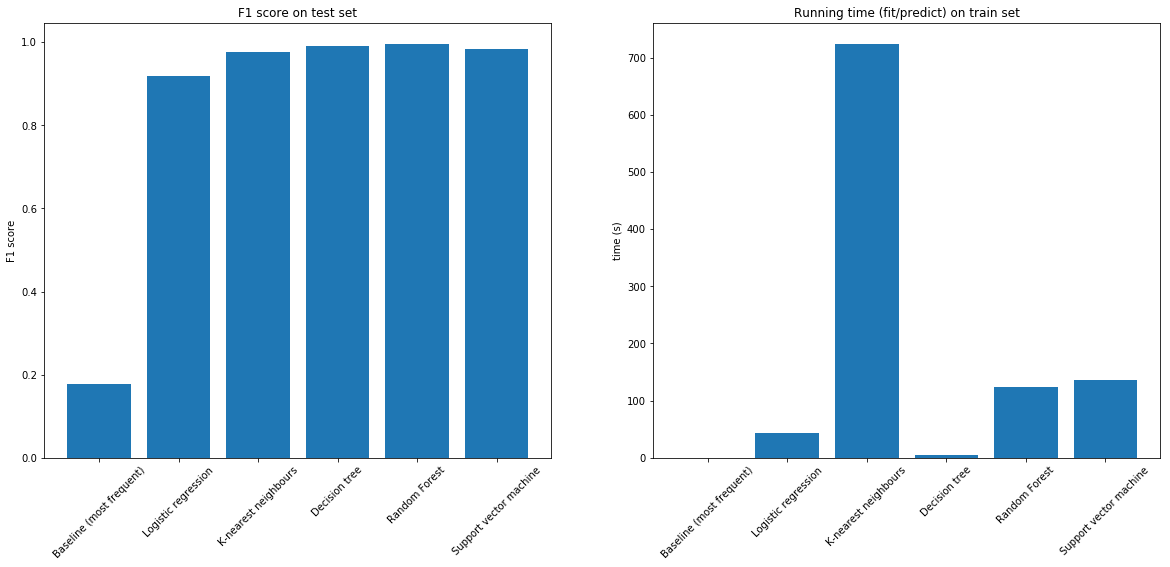

In [62]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(20,8))

# F1 score on test set
ax[0].bar(x=['Baseline (most frequent)','Logistic regression','K-nearest neighbours','Decision tree','Random Forest','Support vector machine'],
          height=[f1_score(y_te,y_pred_mf,average=average_strategy),
                  f1_logreg,
                  f1_knn,
                  f1_dt,
                  f1_rf,
                  f1_svc
                 ])
ax[0].set_ylabel('F1 score')
ax[0].set_title('F1 score on test set')
ax[0].tick_params(axis='x', rotation=45)

# Running time fit/predict on train set
ax[1].bar(x=['Baseline (most frequent)','Logistic regression','K-nearest neighbours','Decision tree','Random Forest','Support vector machine'],
          height=[time_baseline,
                  time_logreg,
                  time_knn,
                  time_dt,
                  time_rf,
                  time_svc
                 ])
ax[1].set_ylabel('time (s)')
ax[1].set_title('Running time (fit/predict) on train set')
ax[1].tick_params(axis='x', rotation=45)

plt.show()